In [25]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F

In [26]:
class DownConvLayer(nn.Module):
    def __init__(self, dim):
        super(DownConvLayer, self).__init__()
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.pool(x)
        return x

以上代码定义了一个名为DownConvLayer的类，主要功能是实现了一个下采样卷积层，用于在卷积神经网络中进行特征提取和降维。在类的初始化方法中，定义了两个子模块。第一个子模块是使用nn.Conv2d函数定义的卷积层，输入和输出的通道数都是dim，卷积核大小为3x3，padding为1，表示在输入特征图周围填充一圈0，使得卷积操作后特征图大小不变。第二个子模块是nn.MaxPool2d，用于进行最大池化操作，将输入特征图尺寸缩小一半。在forward方法中，接收输入x，并通过卷积操作、ReLU激活函数和最大池化操作进行特征提取和降维，最后返回降维后的特征图。

In [27]:
# 创建一个DownConvLayer对象
down_conv = DownConvLayer(dim=1)
# 创建一个输入张量，假设尺寸为[batch_size, channel, height, width]
input_tensor = th.randn(1, 1, 28, 28)
# 将输入张量传递给DownConvLayer的forward方法进行前向计算
output_tensor = down_conv(input_tensor)
# 输出降维后的特征图尺寸
print(output_tensor.shape)

torch.Size([1, 1, 14, 14])


在测试用例中，我们创建了一个包含3个通道的输入张量，尺寸为[1, 3, 32, 32]。然后将输入张量传递给DownConvLayer的forward方法进行前向计算，得到输出张量output_tensor。最后打印输出张量的形状，可以看到输出特征图的尺寸被压缩了一半，即成为[1, 3, 16, 16]。

In [28]:
class UpConvLayer(nn.Module):
    def __init__(self, dim):
        super(UpConvLayer, self).__init__()
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.upsample(x)
        return x

以上代码定义了一个名为UpConvLayer的类，主要功能是实现了一个上采样卷积层，用于在卷积神经网络中进行特征上采样和提取更细致的特征。在类的初始化方法中，定义了两个子模块。第一个子模块是使用nn.Conv2d函数定义的卷积层，具体参数和作用与DownConvLayer一致。第二个子模块是nn.Upsample，用于进行上采样操作，通过指定scale_factor参数来确定上采样的倍数，mode参数设置为"nearest"表示使用最近邻插值。在forward方法中，接收输入x，并通过卷积操作、ReLU激活函数和上采样操作进行特征提取和上采样，最后返回上采样后的特征图。

In [29]:
# 创建一个UpConvLayer对象
up_conv = UpConvLayer(dim=1)
# 创建一个输入张量，假设尺寸为[batch_size, channel, height, width]
input_tensor = th.randn(1, 1, 14, 14)
# 将输入张量传递给UpConvLayer的forward方法进行前向计算
output_tensor = up_conv(input_tensor)
# 输出上采样后的特征图尺寸
print(output_tensor.shape)

torch.Size([1, 1, 28, 28])


在测试用例中，我们创建了一个包含3个通道的输入张量，尺寸为[1, 3, 16, 16]。然后将输入张量传递给UpConvLayer的forward方法进行前向计算，得到输出张量output_tensor。最后打印输出张量的形状，可以看到输出特征图的尺寸被放大了一倍，即成为[1, 3, 32, 32]。

In [30]:
class Encoder(nn.Module):
    def __init__(self, dim, layer_num=3):
        super(Encoder, self).__init__()
        self.convs = nn.ModuleList([DownConvLayer(dim) for _ in range(layer_num)])

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        return x

In [31]:
class Decoder(nn.Module):
    def __init__(self, dim, layer_num=3):
        super(Decoder, self).__init__()
        self.convs = nn.ModuleList([UpConvLayer(dim) for _ in range(layer_num)])
        self.final_conv = nn.Conv2d(dim, 1, 3, stride=1, padding=1)

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        reconstruct = self.final_conv(x)
        return reconstruct

以上代码定义了一个Encoder类和一个Decoder类，分别用于实现编码器和解码器的功能。Encoder类中包含一个nn.ModuleList对象self.convs，根据layer_num参数的设置，通过循环创建layer_num个DownConvLayer实例，并将它们存储在self.convs中。在Encoder类的forward方法中，对于self.convs中的每个DownConvLayer实例，将输入x传递给它们进行特征提取和降维操作，并将结果作为下一个DownConvLayer的输入。最后返回最后一个DownConvLayer的输出结果。Decoder类中也包含一个nn.ModuleList对象self.convs，用于存储多个UpConvLayer类的实例，以及一个最终的卷积层self.final_conv。初始化方法与Encoder类类似，根据layer_num参数的设置，通过循环创建layer_num个UpConvLayer实例，并将它们存储在self.convs中。同时，创建一个卷积层self.final_conv，用于将解码器的输出特征图映射为最终的重建图像。在Decoder类的forward方法中，对于self.convs中的每个UpConvLayer实例，将输入x传递给它们进行特征上采样和提取更细致的特征操作，并将结果作为下一个UpConvLayer的输入。最后将最后一个UpConvLayer的输出结果通过self.final_conv进行卷积运算，得到最终的重建图像。

In [32]:
# 创建一个Encoder对象和一个Decoder对象
encoder = Encoder(dim=1, layer_num=2)
decoder = Decoder(dim=1, layer_num=2)
# 创建一个输入张量，假设尺寸为[batch_size, channel, height, width]
input_tensor = th.randn(1, 1, 28, 28)
# 将输入张量传递给Encoder的forward方法进行前向计算
encoded_tensor = encoder(input_tensor)
# 输出编码后图像的尺寸
print(encoded_tensor.shape)
# 将编码后的张量传递给Decoder的forward方法进行前向计算
reconstructed_tensor = decoder(encoded_tensor)
# 输出重建图像的尺寸
print(reconstructed_tensor.shape)

torch.Size([1, 1, 7, 7])
torch.Size([1, 1, 28, 28])


In [33]:
class AutoEncoderModel(nn.Module):
    def __init__(self):
        super(AutoEncoderModel, self).__init__()
        self.encoder = Encoder(1, layer_num=1)
        self.decoder = Decoder(1, layer_num=1)

    def forward(self, inputs):
        latent = self.encoder(inputs)
        reconstruct_img = self.decoder(latent)
        return latent, reconstruct_img

In [34]:
import torchvision
import torchvision.transforms as transforms

In [41]:
# 加载和预处理MNIST数据集
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = th.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
# 创建自编码器模型实例、优化器和损失函数
model = AutoEncoderModel()
optimizer = th.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.01)
criterion = nn.MSELoss()
# 训练自编码器模型
num_epochs = 20
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model.to(device)

AutoEncoderModel(
  (encoder): Encoder(
    (convs): ModuleList(
      (0): DownConvLayer(
        (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (decoder): Decoder(
    (convs): ModuleList(
      (0): UpConvLayer(
        (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (upsample): Upsample(scale_factor=2.0, mode=nearest)
      )
    )
    (final_conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [42]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        images, _ = data
        images = images.to(device)

        optimizer.zero_grad()
        _, reconstructed_images = model(images)
        loss = criterion(images, reconstructed_images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training finished!")

Epoch [1/20], Loss: 0.1594
Epoch [2/20], Loss: 0.0537
Epoch [3/20], Loss: 0.0401
Epoch [4/20], Loss: 0.0307
Epoch [5/20], Loss: 0.0241
Epoch [6/20], Loss: 0.0194
Epoch [7/20], Loss: 0.0158
Epoch [8/20], Loss: 0.0132
Epoch [9/20], Loss: 0.0113
Epoch [10/20], Loss: 0.0101
Epoch [11/20], Loss: 0.0092
Epoch [12/20], Loss: 0.0086
Epoch [13/20], Loss: 0.0081
Epoch [14/20], Loss: 0.0077
Epoch [15/20], Loss: 0.0074
Epoch [16/20], Loss: 0.0073
Epoch [17/20], Loss: 0.0071
Epoch [18/20], Loss: 0.0070
Epoch [19/20], Loss: 0.0070
Epoch [20/20], Loss: 0.0069
Training finished!


In [43]:
import matplotlib.pyplot as plt

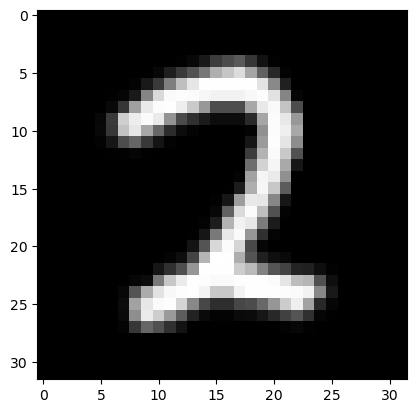

In [44]:
image = images[1].cpu().numpy()
image = image.squeeze()
plt.imshow(image, cmap="gray")
plt.show()

In [66]:
image.shape

(32, 32)

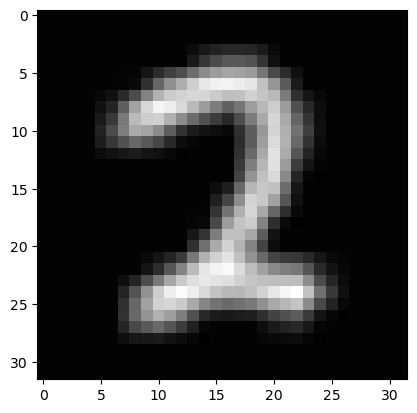

In [45]:
image = reconstructed_images[1].cpu().detach().numpy()
image = image.squeeze()
plt.imshow(image, cmap="gray")
plt.show()


In [46]:
import numpy as np


In [47]:
def load_image(path):
    return np.array(Image.open(path))


In [48]:
model.eval()


AutoEncoderModel(
  (encoder): Encoder(
    (convs): ModuleList(
      (0): DownConvLayer(
        (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (decoder): Decoder(
    (convs): ModuleList(
      (0): UpConvLayer(
        (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (upsample): Upsample(scale_factor=2.0, mode=nearest)
      )
    )
    (final_conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [72]:
from PIL import Image
import os

model.eval()

# 读取templates文件夹下的所有图片
template_dir = './templates'
template_images = os.listdir(template_dir)

# 创建一个空的list，用于存储所有的图片的latent representation
all_latents = []

for img_name in template_images:
    # 打开图片并进行预处理
    img_path = os.path.join(template_dir, img_name)
    img = Image.open(img_path).convert('L')  # 转换为灰度图，如果你的模型输入为彩色图像，这里需要进行相应改变
    img = transform(img)  # 使用和训练模型时相同的转换
    img = img.unsqueeze(0).to(device)  # 增加一个批量维度，并将数据发送到设备

    # 通过模型得到latent representation
    with th.no_grad():
        latent, _ = model(img)
        all_latents.append(latent)

# 此时，all_latents列表中存储的就是所有模板图片的latent representation

In [74]:
len(all_latents)

10

In [76]:
from scipy.spatial import distance

# 读取tests文件夹下的所有图片
test_dir = './tests'
test_images = os.listdir(test_dir)

# 遍历所有测试图片
for img_name in test_images:
    # 打开图片并进行预处理
    img_path = os.path.join(test_dir, img_name)
    img = Image.open(img_path).convert('L')  # 转换为灰度图，如果你的模型输入为彩色图像，这里需要进行相应改变
    img = transform(img)  # 使用和训练模型时相同的转换
    img = img.unsqueeze(0).to(device)  # 增加一个批量维度，并将数据发送到设备

    # 通过模型得到latent representation
    with th.no_grad():
        test_latent, _ = model(img)

    # 计算测试图片的latent representation与所有模板图片的latent representation的距离
    distances = [distance.euclidean(test_latent.cpu().numpy().flatten(), template_latent.cpu().numpy().flatten()) for template_latent in all_latents]

    # 找到距离最小的模板图片
    min_distance_idx = np.argmin(distances)
    matched_template = template_images[min_distance_idx]

    print(f"The test image {img_name} matches best with template image {matched_template}")


The test image 0.png matches best with template image 0.png
The test image 1.png matches best with template image 1.png
The test image 2.png matches best with template image 5.png
The test image 3.png matches best with template image 5.png
The test image 4.png matches best with template image 2.png
The test image 5.png matches best with template image 5.png
The test image 6.png matches best with template image 5.png
The test image 7.png matches best with template image 5.png
The test image 8.png matches best with template image 5.png
The test image 9.png matches best with template image 4.png
